<a href="https://colab.research.google.com/github/nkikn/Facial-Expression-Recognition/blob/main/attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
!pip install wandb torch torchvision pandas numpy matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Upload your kaggle.json to Colab and run:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the dataset
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!unzip -q challenges-in-representation-learning-facial-expression-recognition-challenge.zip

 84% 240M/285M [00:00<00:00, 752MB/s] 
100% 285M/285M [00:00<00:00, 816MB/s]


In [5]:
# Facial Expression Recognition - Simple CNN Baseline
# Notebook 1: Simple CNN Architecture

# Cell 1: Setup and Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import wandb
import os
from tqdm import tqdm
import time


In [37]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Cell 2: Wandb Setup
# Initialize Wandb
wandb.login()

# Wandb configuration
config = {
    'model_name': 'test_overfit',
    'learning_rate': 0.0001,
    'batch_size': 128,
    'epochs': 30,
    'optimizer': 'Adam',
    'loss_function': 'CrossEntropyLoss',
}

# Initialize wandb run
run = wandb.init(
    project="facial-expression-recognition",
    name="test_overfit",
    config=config,
)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Using device: cuda


best_val_accuracy,▁▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▂▃▃▄▄▅▆▆▇█
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███▁▁▁▂▂▂▂▃▃▃
epoch_time,▇▆▇▆▇▇▅▇▇█▆▇▇▇▆█▇▇▆▇█▇▆▇▇▇▆▅█▅▂▂▃▁▁▁▄▁▁▁
learning_rate,██████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁██████████
total_parameters,▁▁
train_accuracy,▁▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▂▃▄▄▅▅▆▇▇█
train_loss,█▇▇▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▇▆▅▅▄▄▃▃▂▁
trainable_parameters,▁▁
val_accuracy,▁▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▂▃▃▄▄▅▆▆▇█
val_loss,█▇▇▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▇▇▆▅▅▄▃▃▂▁
best_val_accuracy,83.0123


In [38]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader


class My_Set(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels']
        image = np.array([int(x) for x in pixels.split()]).reshape(48, 48)
        image = Image.fromarray(image.astype(np.uint8), mode='L')

        if self.transform:
            image = self.transform(image)

        label = self.data.iloc[idx]['emotion']
        return image, label


train_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),    # randomly flip image horizontally
    # transforms.RandomRotation(10),        # randomly rotate by ±10 degrees
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # small translation
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),  # no augmentation on validation
])

from sklearn.model_selection import train_test_split

train_df = pd.read_csv('train.csv')
train_indices, val_indices = train_test_split(
    range(len(train_df)),
    test_size=0.2,
    stratify=train_df['emotion'],
    random_state=42
)



train_dataset = My_Set(train_df, transform=train_transform)
val_dataset = My_Set(train_df, transform=val_transform)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=2,
    # sampler=sampler
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=2
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


Training samples: 28709
Validation samples: 28709


In [39]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.size()
        Q = self.query(x).view(B, -1, H*W)
        K = self.key(x).view(B, -1, H*W)
        V = self.value(x).view(B, -1, H*W)

        attention = torch.bmm(Q.permute(0, 2, 1), K)
        attention = torch.softmax(attention, dim=-1)

        out = torch.bmm(V, attention.permute(0, 2, 1)).view(B, C, H, W)
        return self.gamma * out + x

class CNNWithAttention(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.attn = SelfAttentionBlock(64)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.attn(x)
        x = self.conv2(x)
        return self.fc(x)


In [40]:

# Initialize model
model = CNNWithAttention().to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 4,800,344
Trainable parameters: 4,800,344


In [41]:

# Log model info to wandb
wandb.log({"total_parameters": total_params, "trainable_parameters": trainable_params})

# weight_decay = 1e-4  # small positive value to regularize weights

# Cell 5: Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)


In [42]:

# Cell 6: Training Functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc="Training")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({
            'Loss': f'{running_loss/len(train_loader):.4f}',
            'Acc': f'{100*correct/total:.2f}%'
        })

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc


In [43]:

# Validation function
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc, all_preds, all_targets

In [44]:

# Cell 7: Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        start_time = time.time()

        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validation phase
        val_loss, val_acc, val_predictions, val_labels = validate_epoch(model, val_loader, criterion, device)

        # Update learning rate
        scheduler.step()

        # Calculate epoch time
        epoch_time = time.time() - start_time

        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Log to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "learning_rate": optimizer.param_groups[0]['lr'],
            "epoch_time": epoch_time
        })

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_simple_cnn.pth')
            wandb.log({"best_val_accuracy": best_val_acc})

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Epoch Time: {epoch_time:.2f}s")

        # Early stopping check (optional)
        if epoch > 20 and val_acc < best_val_acc - 5:  # Stop if val acc drops by 5%
            print("Early stopping triggered")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies, val_predictions, val_labels


In [45]:

# Cell 8: Train Model
print("Starting training...")
train_losses, train_accs, val_losses, val_accs, final_predictions, final_labels = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, config['epochs']
)


Starting training...

Epoch 1/30
----------


Training: 100%|██████████| 225/225 [00:26<00:00,  8.56it/s, Loss=1.7319, Acc=29.53%]


Train Loss: 1.7319, Train Acc: 29.53%
Val Loss: 1.6424, Val Acc: 35.14%
Epoch Time: 47.94s

Epoch 2/30
----------


Training: 100%|██████████| 225/225 [00:25<00:00,  8.68it/s, Loss=1.6017, Acc=38.59%]


Train Loss: 1.6017, Train Acc: 38.59%
Val Loss: 1.5564, Val Acc: 39.86%
Epoch Time: 47.58s

Epoch 3/30
----------


Training: 100%|██████████| 225/225 [00:25<00:00,  8.73it/s, Loss=1.5459, Acc=41.01%]


Train Loss: 1.5459, Train Acc: 41.01%
Val Loss: 1.5166, Val Acc: 41.99%
Epoch Time: 47.37s

Epoch 4/30
----------


Training: 100%|██████████| 225/225 [00:25<00:00,  8.70it/s, Loss=1.5060, Acc=42.51%]


Train Loss: 1.5060, Train Acc: 42.51%
Val Loss: 1.4811, Val Acc: 43.68%
Epoch Time: 48.01s

Epoch 5/30
----------


Training: 100%|██████████| 225/225 [00:27<00:00,  8.32it/s, Loss=1.4634, Acc=44.44%]


Train Loss: 1.4634, Train Acc: 44.44%
Val Loss: 1.4320, Val Acc: 45.67%
Epoch Time: 50.28s

Epoch 6/30
----------


Training: 100%|██████████| 225/225 [00:24<00:00,  9.30it/s, Loss=1.4223, Acc=46.01%]


Train Loss: 1.4223, Train Acc: 46.01%
Val Loss: 1.3871, Val Acc: 47.54%
Epoch Time: 47.73s

Epoch 7/30
----------


Training: 100%|██████████| 225/225 [00:24<00:00,  9.33it/s, Loss=1.3882, Acc=47.40%]


Train Loss: 1.3882, Train Acc: 47.40%
Val Loss: 1.3724, Val Acc: 48.47%
Epoch Time: 47.24s

Epoch 8/30
----------


Training: 100%|██████████| 225/225 [00:24<00:00,  9.04it/s, Loss=1.3585, Acc=48.73%]


Train Loss: 1.3585, Train Acc: 48.73%
Val Loss: 1.3353, Val Acc: 49.01%
Epoch Time: 46.71s

Epoch 9/30
----------


Training: 100%|██████████| 225/225 [00:25<00:00,  8.75it/s, Loss=1.3276, Acc=49.89%]


Train Loss: 1.3276, Train Acc: 49.89%
Val Loss: 1.3402, Val Acc: 49.96%
Epoch Time: 49.33s

Epoch 10/30
----------


Training: 100%|██████████| 225/225 [00:25<00:00,  8.71it/s, Loss=1.3053, Acc=50.77%]


Train Loss: 1.3053, Train Acc: 50.77%
Val Loss: 1.2796, Val Acc: 52.14%
Epoch Time: 48.18s

Epoch 11/30
----------


Training: 100%|██████████| 225/225 [00:25<00:00,  8.89it/s, Loss=1.2775, Acc=51.82%]


Train Loss: 1.2775, Train Acc: 51.82%
Val Loss: 1.2500, Val Acc: 53.53%
Epoch Time: 48.90s

Epoch 12/30
----------


Training: 100%|██████████| 225/225 [00:23<00:00,  9.38it/s, Loss=1.2535, Acc=52.71%]


Train Loss: 1.2535, Train Acc: 52.71%
Val Loss: 1.2541, Val Acc: 52.43%
Epoch Time: 47.35s

Epoch 13/30
----------


Training: 100%|██████████| 225/225 [00:23<00:00,  9.39it/s, Loss=1.2343, Acc=53.68%]


Train Loss: 1.2343, Train Acc: 53.68%
Val Loss: 1.2077, Val Acc: 55.25%
Epoch Time: 47.08s

Epoch 14/30
----------


Training: 100%|██████████| 225/225 [00:26<00:00,  8.64it/s, Loss=1.2163, Acc=54.48%]


Train Loss: 1.2163, Train Acc: 54.48%
Val Loss: 1.1855, Val Acc: 55.73%
Epoch Time: 49.22s

Epoch 15/30
----------


Training: 100%|██████████| 225/225 [00:25<00:00,  8.73it/s, Loss=1.1952, Acc=55.53%]


Train Loss: 1.1952, Train Acc: 55.53%
Val Loss: 1.1691, Val Acc: 56.18%
Epoch Time: 47.14s

Epoch 16/30
----------


Training: 100%|██████████| 225/225 [00:25<00:00,  8.72it/s, Loss=1.1538, Acc=57.36%]


Train Loss: 1.1538, Train Acc: 57.36%
Val Loss: 1.1473, Val Acc: 57.88%
Epoch Time: 47.32s

Epoch 17/30
----------


Training: 100%|██████████| 225/225 [00:25<00:00,  8.84it/s, Loss=1.1476, Acc=57.71%]


Train Loss: 1.1476, Train Acc: 57.71%
Val Loss: 1.1420, Val Acc: 57.99%
Epoch Time: 47.60s

Epoch 18/30
----------


Training: 100%|██████████| 225/225 [00:25<00:00,  8.96it/s, Loss=1.1445, Acc=57.89%]


Train Loss: 1.1445, Train Acc: 57.89%
Val Loss: 1.1392, Val Acc: 58.13%
Epoch Time: 48.61s

Epoch 19/30
----------


Training: 100%|██████████| 225/225 [00:26<00:00,  8.65it/s, Loss=1.1411, Acc=58.00%]


Train Loss: 1.1411, Train Acc: 58.00%
Val Loss: 1.1367, Val Acc: 58.22%
Epoch Time: 49.28s

Epoch 20/30
----------


Training: 100%|██████████| 225/225 [00:25<00:00,  8.82it/s, Loss=1.1388, Acc=58.30%]


Train Loss: 1.1388, Train Acc: 58.30%
Val Loss: 1.1344, Val Acc: 58.54%
Epoch Time: 47.34s

Epoch 21/30
----------


Training: 100%|██████████| 225/225 [00:25<00:00,  8.74it/s, Loss=1.1360, Acc=58.34%]


Train Loss: 1.1360, Train Acc: 58.34%
Val Loss: 1.1314, Val Acc: 58.64%
Epoch Time: 47.26s

Epoch 22/30
----------


Training: 100%|██████████| 225/225 [00:25<00:00,  8.76it/s, Loss=1.1346, Acc=58.42%]


Train Loss: 1.1346, Train Acc: 58.42%
Val Loss: 1.1284, Val Acc: 58.54%
Epoch Time: 47.22s

Epoch 23/30
----------


Training: 100%|██████████| 225/225 [00:25<00:00,  8.65it/s, Loss=1.1309, Acc=58.45%]


Train Loss: 1.1309, Train Acc: 58.45%
Val Loss: 1.1273, Val Acc: 58.60%
Epoch Time: 51.03s

Epoch 24/30
----------


Training: 100%|██████████| 225/225 [00:24<00:00,  9.23it/s, Loss=1.1291, Acc=58.69%]


Train Loss: 1.1291, Train Acc: 58.69%
Val Loss: 1.1242, Val Acc: 58.81%
Epoch Time: 47.85s

Epoch 25/30
----------


Training: 100%|██████████| 225/225 [00:23<00:00,  9.48it/s, Loss=1.1263, Acc=58.70%]


Train Loss: 1.1263, Train Acc: 58.70%
Val Loss: 1.1211, Val Acc: 59.17%
Epoch Time: 47.24s

Epoch 26/30
----------


Training: 100%|██████████| 225/225 [00:24<00:00,  9.12it/s, Loss=1.1227, Acc=58.82%]


Train Loss: 1.1227, Train Acc: 58.82%
Val Loss: 1.1195, Val Acc: 59.13%
Epoch Time: 47.20s

Epoch 27/30
----------


Training: 100%|██████████| 225/225 [00:25<00:00,  8.72it/s, Loss=1.1207, Acc=59.04%]


Train Loss: 1.1207, Train Acc: 59.04%
Val Loss: 1.1171, Val Acc: 59.29%
Epoch Time: 47.42s

Epoch 28/30
----------


Training: 100%|██████████| 225/225 [00:27<00:00,  8.05it/s, Loss=1.1188, Acc=59.09%]


Train Loss: 1.1188, Train Acc: 59.09%
Val Loss: 1.1140, Val Acc: 59.36%
Epoch Time: 50.36s

Epoch 29/30
----------


Training: 100%|██████████| 225/225 [00:24<00:00,  9.09it/s, Loss=1.1159, Acc=59.30%]


Train Loss: 1.1159, Train Acc: 59.30%
Val Loss: 1.1119, Val Acc: 59.53%
Epoch Time: 48.28s

Epoch 30/30
----------


Training: 100%|██████████| 225/225 [00:23<00:00,  9.51it/s, Loss=1.1144, Acc=59.23%]


Train Loss: 1.1144, Train Acc: 59.23%
Val Loss: 1.1103, Val Acc: 59.64%
Epoch Time: 47.15s


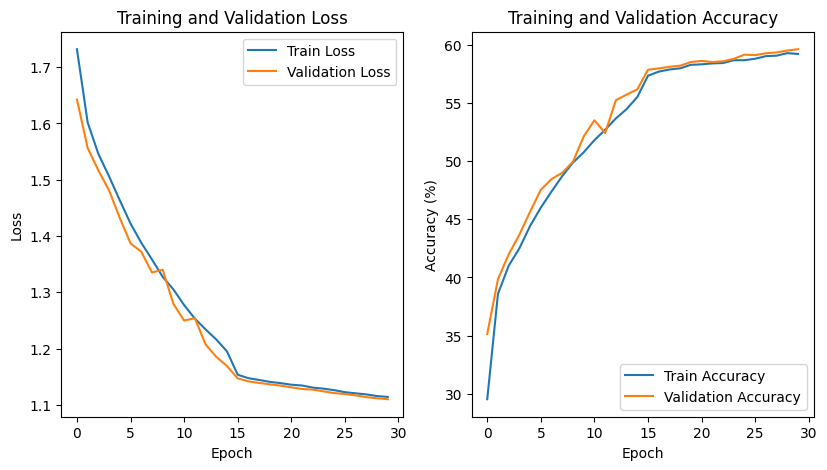

In [46]:

# Cell 9: Results Analysis and Visualization
# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()


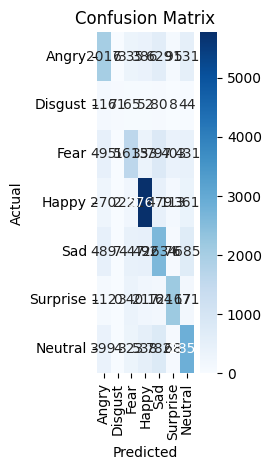

In [47]:

# Confusion Matrix
plt.subplot(1, 3, 3)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
cm = confusion_matrix(final_labels, final_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.savefig('simple_cnn_results.png', dpi=300, bbox_inches='tight')
plt.show()


In [48]:

# Log plots to wandb
wandb.log({"training_curves": wandb.Image(plt)})

# Cell 10: Detailed Performance Analysis
# Classification Report
print("\nClassification Report:")
print(classification_report(final_labels, final_predictions, target_names=class_names))

# Calculate per-class accuracy
class_accuracies = {}
for i, class_name in enumerate(class_names):
    class_mask = np.array(final_labels) == i
    if np.sum(class_mask) > 0:
        class_acc = np.sum(np.array(final_predictions)[class_mask] == i) / np.sum(class_mask)
        class_accuracies[class_name] = class_acc * 100

print("\nPer-class Accuracies:")
for class_name, acc in class_accuracies.items():
    print(f"{class_name}: {acc:.2f}%")

# Log final metrics to wandb
final_metrics = {
    "final_train_accuracy": train_accs[-1],
    "final_val_accuracy": val_accs[-1],
    "best_val_accuracy": max(val_accs),
    "final_train_loss": train_losses[-1],
    "final_val_loss": val_losses[-1],
}

# Add per-class accuracies
for class_name, acc in class_accuracies.items():
    final_metrics[f"class_accuracy_{class_name.lower()}"] = acc

wandb.log(final_metrics)



Classification Report:
              precision    recall  f1-score   support

       Angry       0.52      0.50      0.51      3995
     Disgust       0.75      0.16      0.27       436
        Fear       0.48      0.39      0.43      4097
       Happy       0.74      0.80      0.77      7215
         Sad       0.47      0.55      0.51      4830
    Surprise       0.74      0.68      0.71      3171
     Neutral       0.56      0.57      0.57      4965

    accuracy                           0.60     28709
   macro avg       0.61      0.52      0.54     28709
weighted avg       0.60      0.60      0.59     28709


Per-class Accuracies:
Angry: 50.49%
Disgust: 16.28%
Fear: 39.37%
Happy: 79.96%
Sad: 54.53%
Surprise: 68.34%
Neutral: 57.42%


<Figure size 640x480 with 0 Axes>

In [49]:

# # Cell 11: Model Summary and Insights
# print("\n" + "="*50)
# print("SIMPLE CNN MODEL SUMMARY")
# print("="*50)
# print(f"Architecture: {config['architecture']}")
# print(f"Total Parameters: {total_params:,}")
# print(f"Best Validation Accuracy: {max(val_accs):.2f}%")
# print(f"Final Validation Accuracy: {val_accs[-1]:.2f}%")
# print(f"Training Time: {len(train_accs)} epochs")

# print("\nKey Observations:")
# print("1. Simple architecture with only 2 conv layers")
# print("2. No regularization techniques applied")
# print("3. Basic architecture serves as baseline")
# print("4. Limited capacity may cause underfitting")
# print("5. Good starting point for progressive development")

# print("\nNext Steps:")
# print("1. Increase model depth (more conv layers)")
# print("2. Add regularization (BatchNorm, Dropout)")
# print("3. Experiment with different architectures")
# print("4. Apply data augmentation")


In [50]:

# Cell 12: Save Model and Artifacts
# Save final model
torch.save(model.state_dict(), 'test_overfit.pth')

# Save model artifact to wandb
artifact = wandb.Artifact('simple_cnn_model', type='model')
artifact.add_file('test_overfit.pth')
wandb.log_artifact(artifact)

# Save training history
import pickle
history = {
    'train_losses': train_losses,
    'train_accuracies': train_accs,
    'val_losses': val_losses,
    'val_accuracies': val_accs,
    'config': config,
    'final_predictions': final_predictions,
    'final_labels': final_labels
}


with open('test_overfit_history.pkl', 'wb') as f:
    pickle.dump(history, f)

# Finish wandb run
wandb.finish()

print("\nTraining completed and logged to Wandb!")
print("Model saved as 'test_overfit.pth'")
print("Training history saved as 'test_overfit_history.pkl'")

best_val_accuracy,▁▂▃▃▄▅▅▅▅▆▆▇▇▇▇████████████
class_accuracy_angry,▁
class_accuracy_disgust,▁
class_accuracy_fear,▁
class_accuracy_happy,▁
class_accuracy_neutral,▁
class_accuracy_sad,▁
class_accuracy_surprise,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch_time,▃▂▂▃▇▃▂▁▅▃▅▂▂▅▂▂▂▄▅▂▂▂█▃▂▂▂▇▄▂
final_train_accuracy,▁



Training completed and logged to Wandb!
Model saved as 'test_overfit.pth'
Training history saved as 'test_overfit_history.pkl'
